<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/adversarial_attack/adversarial_local_fgsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adversarial attack with FGSM

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
model.trainable = False
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


In [3]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [5]:
img_raw = tf.io.read_file('adam.jpg')
img = tf.image.decode_image(img_raw)

img = preprocess(img)
img_probs = model.predict(img)

##Original image

49152/35363 [=========================================] - 0s 0us/step


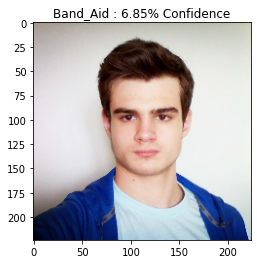

In [6]:
plt.figure()
plt.imshow(img[0] * 0.5 + 0.5)  # To change [-1, 1] to [0, 1]
_, img_class, class_confidence = get_imagenet_label(img_probs)
plt.title('{} : {:.2f}% Confidence'.format(img_class, class_confidence*100))
plt.show()

##Adversarial image

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_img, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_img)
    pred = model(input_img)
    loss = loss_object(input_label, pred)

  gradient = tape.gradient(loss, input_img)
  signed_grad = tf.sign(gradient)
  return signed_grad

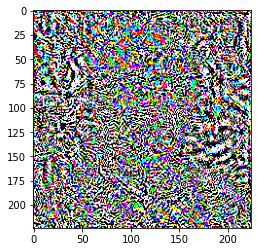

In [19]:
goldfish_index = 1
label = tf.one_hot(goldfish_index, img_probs.shape[-1])
label = tf.reshape(label, (1, img_probs.shape[-1]))

perturbations = create_adversarial_pattern(img, label)
plt.imshow(perturbations[0] * 0.5 + 0.5)

###Applying mask to extract local gradients

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


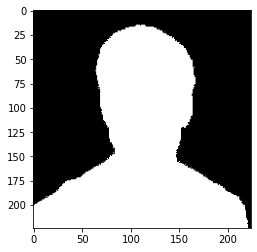

In [20]:
mask_raw = tf.io.read_file('mask.jpg')
mask = tf.image.decode_image(mask_raw)
mask = tf.cast(mask, tf.float32)
mask = tf.image.resize(mask, (224, 224))
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


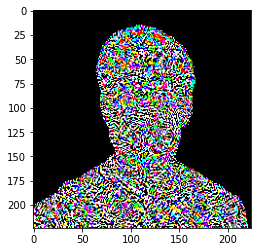

In [21]:
mask = np.array(mask, dtype=np.uint8).reshape((1, 224, 224, 3))
perturbations = np.where(mask > 0.5, perturbations, 0)
plt.imshow(perturbations[0])

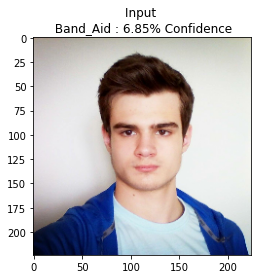

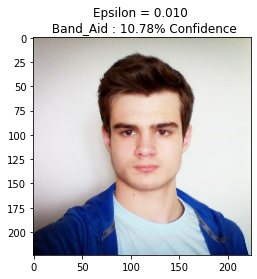

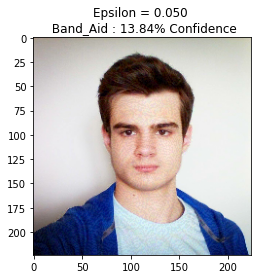

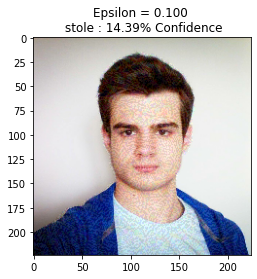

In [28]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

epsilons = [0, 0.01, 0.05, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') 
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = img + eps * perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

###Inverted mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


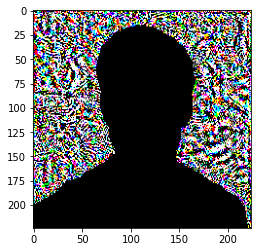

In [30]:
perturbations_inv = create_adversarial_pattern(img, label)
perturbations_inv = np.where(mask < 0.5, perturbations_inv, 0)
plt.imshow(perturbations_inv[0])

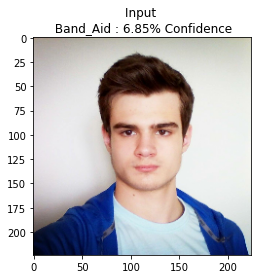

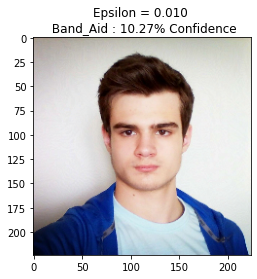

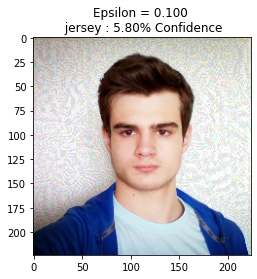

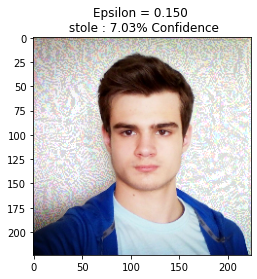

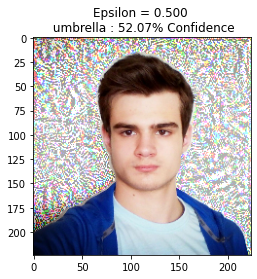

In [35]:
epsilons = [0, 0.01, 0.1, 0.15, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') 
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = img + eps * perturbations_inv
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

In [38]:
adv_img = np.array((adv_x[0]*0.5+0.5) * 255, dtype=np.uint8)
adv_img = Image.fromarray(adv_img.reshape((224, 224, 3)))
adv_img.save('adv_inv.jpg')